In [1]:
import numpy as np 
import pandas as pd 

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from collections import defaultdict
from sklearn.metrics import roc_curve, auc
import os
import pathlib
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import openpyxl.drawing.image
from openpyxl.formatting.rule import ColorScaleRule
from openpyxl.utils.dataframe import dataframe_to_rows
import pandas as pd
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_recall_fscore_support,
)


def generate_classification_report(
    y_true: np.ndarray, y_pred: np.ndarray, y_pred_scored: np.ndarray
) -> pd.DataFrame:
    """Generates pandas-based per-class and aggregated classification metrics.
    Args:
        y_true: ground truth labels
        y_pred:  predicted model labels
    Returns:
        pandas dataframe with main classification metrics
    """
    metrics = defaultdict(lambda: {})
    metrics_names = [
        "precision",
        "recall",
        "f1-score",
        "auc",
        "support",
        "support (%)",
    ]
    avg_names = ["macro", "micro", "weighted"]
    labels = sorted(set(y_true).union(y_pred))
    
    auc = Auc(y_true, y_pred_scored, len(labels))
    
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true=y_true, y_pred=y_pred, average=None, labels=labels,
    )
    r_support = support / support.sum()

    for average in avg_names:
        avg_precision, avg_recall, avg_f1, _ = precision_recall_fscore_support(
            y_true=y_true, y_pred=y_pred, average=average, labels=labels,
        )
       
        avg_metrics = avg_precision, avg_recall, avg_f1
        for k, v in zip(metrics_names[:4], avg_metrics):
            metrics[k][average] = v

    report = pd.DataFrame(
        [precision, recall, f1, auc, support, r_support],
        columns=labels,
        index=metrics_names,
    ).T

    metrics["support"]["macro"] = support.sum()
    metrics["precision"]["accuracy"] = accuracy
    metrics = pd.DataFrame(metrics, index=avg_names + ["accuracy"])

    result = pd.concat((report, metrics)).fillna("")
    result = result[metrics_names]
    return result



def plot_confusion_matrix_heatmap(
    true: np.ndarray, predicted: np.ndarray
) -> None:
    """Plots confusion matrix with seaborn.
    Args:
        true: ground truth labels
        predicted: predicted model labels
    """
    classes = sorted(np.unique(true))
    matrix = confusion_matrix(true, predicted, labels=classes)
    matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]
    matrix = matrix.round(decimals=2)
    sns.heatmap(
        matrix,
        xticklabels=classes,
        yticklabels=classes,
        annot=True,
        fmt="g",
        square=True,
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

def Auc(y_test, y_pred_scored, n_classes):
    y_test_matrix = np.zeros(y_test.shape[0] * n_classes)
    y_test_matrix = y_test_matrix.reshape(-1, n_classes)
    for i, e in enumerate(y_test):
        y_test_matrix[i][e - 1] = 1
    fpr = dict()
    tpr = dict()
    roc_auc = np.zeros(n_classes)
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_matrix[:, i], y_pred_scored[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return roc_auc

In [4]:
train_data = pd.read_csv("train\\train.csv")
test_data = pd.read_csv("test\\test.csv")

In [5]:
train_data.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5


In [6]:
X=train_data.drop(labels=['Id','Cover_Type'],axis=1)
y=train_data['Cover_Type']

**Train Test Split**

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size = 0.2, random_state=40)
y_test = y_test.to_numpy()

**Sklearn RidgeClassifier**

In [8]:
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

rc = RidgeClassifier()
rc.fit(X_train, y_train)
pred = rc.predict(X_test)
y_score_pred = rc.decision_function(X_test)
print("accuracy :", rc.score(X_test, y_test))

accuracy : 0.6273148148148148


In [9]:
confusion_matrix(y_test, pred)

array([[283,  82,   1,   0,  32,   1,  41],
       [128, 201,   4,   2,  94,  13,   5],
       [  0,   0, 196,  67,  16, 141,   0],
       [  0,   0,  41, 367,   0,  48,   0],
       [ 24,  52,  33,  18, 279,  20,   0],
       [  1,  15,  76,  51,  33, 231,   0],
       [ 81,   1,   3,   0,   3,   0, 340]], dtype=int64)

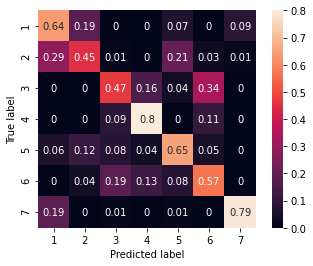

In [10]:
plot_confusion_matrix_heatmap(y_test, pred)

In [11]:
generate_classification_report(y_test, pred, y_score_pred)

,precision,recall,f1-score,auc,support,support (%)
1,0.547389,0.643182,0.591432,0.914035,440,0.145503
2,0.572650,0.449664,0.503759,0.880748,447,0.147817
3,0.553672,0.466667,0.50646,0.905444,420,0.138889
4,0.726733,0.804825,0.763788,0.978934,456,0.150794
5,0.610503,0.65493,0.631937,0.910294,426,0.140873
6,0.508811,0.567568,0.536585,0.906854,407,0.13459
7,0.880829,0.794393,0.835381,0.987029,428,0.141534
macro,0.628655,0.62589,0.624192,,3024,
micro,0.627315,0.627315,0.627315,,,
weighted,0.629932,0.627315,0.625512,,,


**Sklearn KNeighborsClassifier**

In [13]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
y_pred_scored = knn.predict_proba(X_test)
print("accuracy :", knn.score(X_test, y_test))

accuracy : 0.8078703703703703


In [14]:
confusion_matrix(y_test, pred)

array([[291,  71,   2,   0,  20,   0,  56],
       [107, 239,  18,   0,  48,  23,  12],
       [  0,   4, 324,  29,   5,  58,   0],
       [  0,   0,   9, 436,   0,  11,   0],
       [  1,   4,  12,   0, 404,   5,   0],
       [  1,   3,  38,  19,   8, 338,   0],
       [ 12,   5,   0,   0,   0,   0, 411]], dtype=int64)

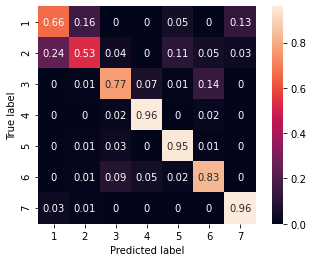

In [15]:
plot_confusion_matrix_heatmap(y_test, pred)

In [16]:
generate_classification_report(y_test, pred, y_pred_scored)

,precision,recall,f1-score,auc,support,support (%)
1,0.706311,0.661364,0.683099,0.920271,440,0.145503
2,0.733129,0.534676,0.61837,0.879207,447,0.147817
3,0.803970,0.771429,0.787363,0.954022,420,0.138889
4,0.900826,0.95614,0.92766,0.994442,456,0.150794
5,0.832990,0.948357,0.886937,0.992346,426,0.140873
6,0.777011,0.830467,0.80285,0.967635,407,0.13459
7,0.858038,0.96028,0.906284,0.991159,428,0.141534
macro,0.801754,0.808959,0.801795,,3024,
micro,0.807870,0.80787,0.80787,,,
weighted,0.802006,0.80787,0.801311,,,


**CatBoost**

In [17]:
import catboost
# print(catboost.__version__)
from catboost import CatBoostClassifier

In [18]:
# метрика 'MultiClass' <!-- ![image.png](attachment:5ad94b38-4bda-4fa0-af10-8f3b7ea74396.png)

In [19]:
%%time
ctb = CatBoostClassifier(iterations=1000, loss_function = 'MultiClass')
ctb.fit(X_train, y_train, verbose=False, plot=True)
pred = ctb.predict(X_test)
y_pred_scored = ctb.predict_proba(X_test)
print("accuracy :", ctb.score(X_test, y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

accuracy : 0.8525132275132276
Wall time: 16.8 s


In [20]:
confusion_matrix(y_test, pred)

array([[338,  71,   0,   0,   5,   1,  25],
       [ 89, 299,  12,   0,  33,   7,   7],
       [  0,   0, 343,  15,   6,  56,   0],
       [  0,   0,   9, 441,   0,   6,   0],
       [  0,  19,  10,   0, 388,   9,   0],
       [  2,   2,  32,   8,   2, 361,   0],
       [ 19,   1,   0,   0,   0,   0, 408]], dtype=int64)

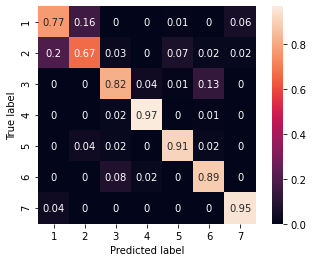

In [21]:
plot_confusion_matrix_heatmap(y_test, pred)

In [22]:
pred = pred.ravel()

In [23]:
generate_classification_report(y_test, pred,y_pred_scored)

,precision,recall,f1-score,auc,support,support (%)
1,0.754464,0.768182,0.761261,0.970807,440,0.145503
2,0.762755,0.668904,0.712753,0.955936,447,0.147817
3,0.844828,0.816667,0.830508,0.983331,420,0.138889
4,0.950431,0.967105,0.958696,0.99847,456,0.150794
5,0.894009,0.910798,0.902326,0.994562,426,0.140873
6,0.820455,0.886978,0.85242,0.987199,407,0.13459
7,0.927273,0.953271,0.940092,0.997162,428,0.141534
macro,0.850602,0.853129,0.851151,,3024,
micro,0.852513,0.852513,0.852513,,,
weighted,0.850789,0.852513,0.850932,,,


In [24]:
# for key,value in ctb.get_all_params().items():
#     print('{}, {}'.format(key,value))

In [25]:
# accuracy_score(y_test, pred)

**XGBoost**

In [26]:
# import xgboost
# # from xgboost import XGBoostClassifier
# from xgboost import XGBClassifier


In [27]:
# xg = XGBClassifier(n_estimators = 100)
# xg.fit(X_train, y_train)
# pred = xg.predict(X_test)

In [31]:
# accuracy_score(y_test, pred)

**TabNet**

In [15]:
!pip install torch

In [16]:
import torch